# Global indicator project - Phoenix, Arizona

## Set up studyregion adminitrative level population data (census block group in Phoenix)


In [1]:
# Libraries used for OSMnx analyses and output
import networkx as nx
import time 
import os
import osmnx as ox
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
import geopandas as gpd

from shapely.geometry import shape,Point, LineString, Polygon

ox.config(use_cache=True, log_console=True)


In [2]:
place = 'phoenix' 

region = 'Arizona, USA' # study region name

studyregion = 'Phoenix, Arizona, USA'

suffix = '_201905'

# configure filenames to save/load datasets
OSM_folder = '../data/OSM'
shap_filepath = '../data/Maricopa_County/MC_Boundary.shp'
admindata_filepath = '../data/Maricopa_County/BlockGroup_Data.shp'

sample_points_filepath = '../data/OSM/phoenix_testing_sample_points_201905/phoenix_testing_sample_points_201905.shp'
sample_points_stats_filepath = '../data/OSM/phoenix_sample_points_stats_201905.csv'

## 1. Load county census block group data

In [3]:
# check city administrative level
blockgroup = gpd.GeoDataFrame.from_file(admindata_filepath)

In [4]:
blockgroup.head(4)

,TRACTCE10,BLOCKCE,BLOCKID10,HOUSING10,POP10,Sum_Employ,geometry
0,012100,2126,040270121002126,5,15,0.0,"POLYGON ((-113.333767 32.93470400000003, -113...."
1,012100,2122,040270121002122,0,0,0.0,"POLYGON ((-113.333812 33.08803399999996, -113...."
2,012100,2120,040270121002120,7,23,0.0,"POLYGON ((-113.333801 33.07349199999997, -113...."
3,012100,2119,040270121002119,0,0,0.0,"POLYGON ((-113.333797 33.05896800000004, -113...."


In [5]:
# define the projection
blockgroup_proj = ox.project_gdf(blockgroup)
len(blockgroup_proj)

73018

## 2. Plot city boundary and population data

In [6]:
def map_variable(df, col):
    values = df.dropna(subset=[col])
    ax = values.plot(column=col, scheme='quantiles', k=6, cmap='YlOrBr', figsize=(10,10))
    plt.show()

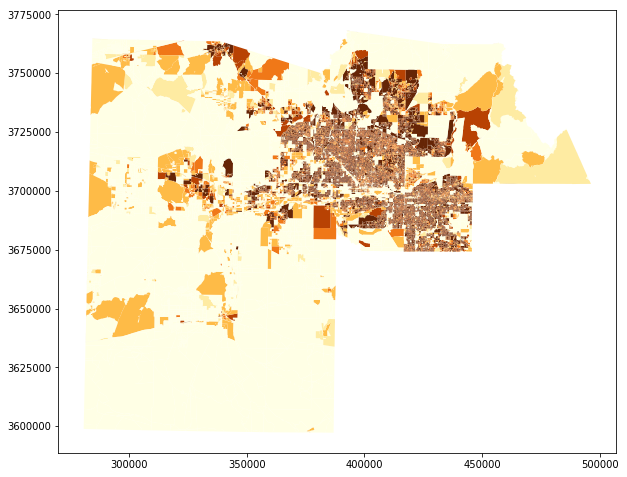

In [7]:
map_variable(blockgroup_proj, 'POP10')

? can we use supplied population data to determine the built-up/urban area of the studyregion

## 2. Load GHS population data

In [8]:
GHS_pop_filepath = '../data/OSM/GHS_proj_2015Pop_250m_phoenix/GHS_proj_2015Pop_250m_phoenix.shp'
GHS_pop_proj = gpd.GeoDataFrame.from_file(GHS_pop_filepath)
GHS_pop_proj.head()

,raster_val,geometry
0,0.7044491171836853,"POLYGON ((333848.9570017507 3763469.437410898,..."
1,0.9279614090919495,"POLYGON ((334180.9548007344 3763469.437410897,..."
2,3.058992862701416,"POLYGON ((334844.9503987008 3763469.437410897,..."
3,1.3544756174087524,"POLYGON ((335176.9481976845 3763469.437410897,..."
4,1.1762453317642212,"POLYGON ((335508.9459966677 3763469.437410898,..."


In [9]:
# change to float type
GHS_pop_proj['raster_val'] = GHS_pop_proj['raster_val'].astype(float)

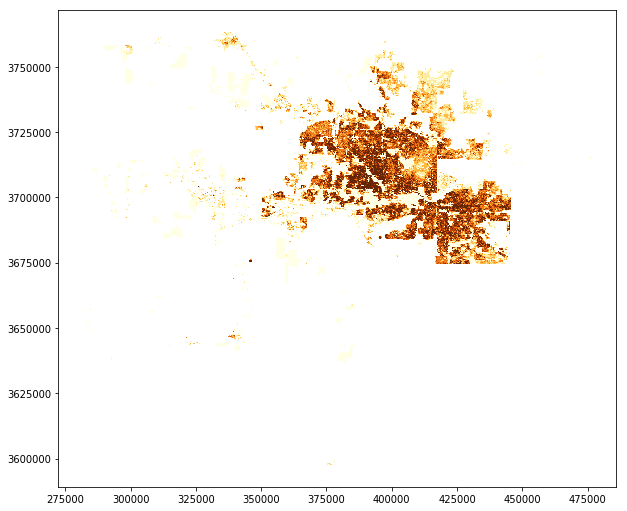

In [10]:
map_variable(GHS_pop_proj, 'raster_val')

In [11]:
# select blocks within the GHS built-up area
blockgroup_proj_clip = blockgroup_proj[blockgroup_proj.centroid.within(GHS_pop_proj.buffer(0.01).unary_union)]

In [18]:
len(blockgroup_proj_clip)

61512

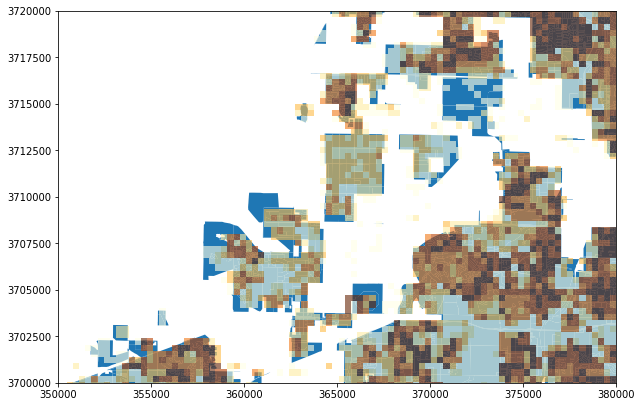

In [17]:
ax = blockgroup_proj.plot(figsize=(10,10))
ax = GHS_pop_proj.plot(ax=ax, column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', alpha=0.6)
ax.set_xlim(350000, 380000)
ax.set_ylim(3700000, 3720000)

plt.show()

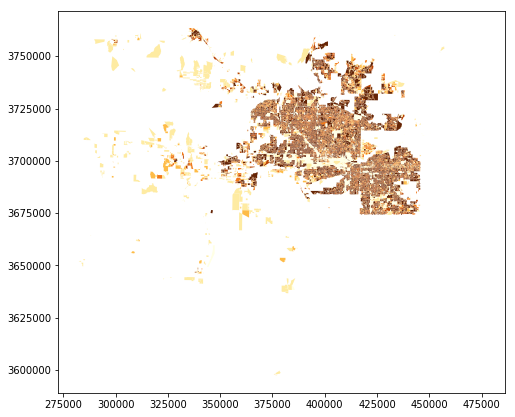

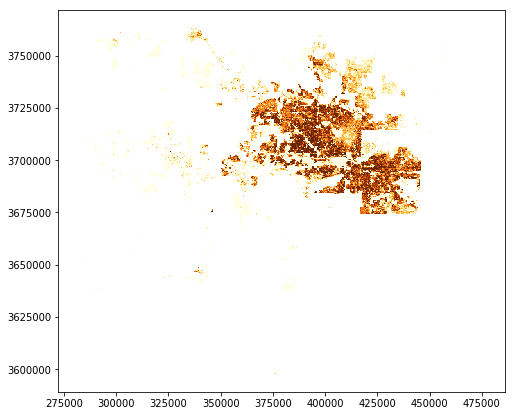

In [24]:
ax = blockgroup_proj.plot(column='POP10', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(8,8))
ax = GHS_pop_proj.plot(column='raster_val', scheme='quantiles', k=6, cmap='YlOrBr', figsize=(8,8))

plt.show()

## 2. Aggregate population grid to blockgroup
What method we should use: aggregate population grid to city blocks (the smallest administrative level data we obtain from the study region)

In [12]:
# create null field for population values
blockgroup_proj_clip['population'] = np.nan    
blockgroup_proj_clip['population'].astype('Int64', inplace=True)
    
# associate analysis_area with aggregate population estimates
pop = 0
for row in range(1, len(blockgroup_proj_clip)):
    area_id = blockgroup_proj_clip[(row-1):row].index
    block_polygon = blockgroup_proj_clip['geometry'].iloc[row]
    mask = GHS_pop_proj.centroid.within(block_polygon)
    area_pop = float(np.sum(GHS_pop_proj[mask]['raster_val']))
    pop += area_pop
    blockgroup_proj_clip.loc[area_id,'population'] = pop
               